# Training Classifier Forearm

In [7]:
!pip install -U --pre efficientnet

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.1)


In [8]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
import cv2

import seaborn as sns
from PIL import Image

from tqdm import tqdm_notebook,tqdm


from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from keras.layers import  Convolution2D,MaxPooling2D,Dense,Flatten,Dropout,GlobalMaxPooling1D
from keras.layers import AveragePooling2D
from keras.models import  Sequential
import imutils
from keras.applications.resnet import ResNet50,ResNet152,preprocess_input,decode_predictions
from keras.applications.densenet import DenseNet121,DenseNet169,preprocess_input,decode_predictions
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import efficientnet.keras as efn 

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Generating MetaDataframes

In [10]:
def returnDf(bodypart,path):

  train_imgs_path=pd.read_csv(path+'MURA-v1.1/train_image_paths.csv',names=['img_path'])
  test_imgs_path=pd.read_csv(path+'MURA-v1.1/valid_image_paths.csv',names=['img_path'])


  train_imgs_path['Body_Part']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  train_imgs_path['Study_No']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  train_imgs_path['label']=train_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])

  test_imgs_path['Body_Part']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  test_imgs_path['Study_No']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  test_imgs_path['label']=test_imgs_path['img_path'].apply(lambda x: str(x.split('/')[4])[7:])


  train_df=train_imgs_path[train_imgs_path['Body_Part']==bodypart]
  test_df=test_imgs_path[test_imgs_path['Body_Part']==bodypart]

  train_df['img_path']=[path + i for i in train_df['img_path']]
  test_df['img_path']=[path + i for i in test_df['img_path']]
  
  #train_labels['Body_Part']=train_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #train_labels['Study_Type']=train_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])
  #test_labels['Body_Part']=test_labels['img_path'].apply(lambda x: str(x.split('/')[2])[3:])
  #test_labels['Study_Type']=test_labels['img_path'].apply(lambda x: str(x.split('/')[4])[:6])


  #train_labels['img_path']=train_imgs_path.iloc[:,0]
  #test_labels['img_path']=test_imgs_path.iloc[:,0]
    
  #train_df=train_labels[train_labels['Body_Part']==bodypart]
  #test_df=test_labels[test_labels['Body_Part']==bodypart]
  #train_df['img_path']=[path + i for i in train_df['img_path']]
  #train_df['label']=train_df['label'].astype('str')
  #test_df['img_path']=[path + i for i in test_df['img_path']]
  #test_df['label']=test_df['label'].astype('str')
  train_df['label']=[str(1) if i=='positive' else str(0) for i in train_df['label']]
  test_df['label']=[str(1) if i=='positive' else str(0) for i in test_df['label']]

  return train_df, test_df

In [11]:
train_df,test_df=returnDf('FOREARM','gdrive/My Drive/Capstone Medical Imaging/Data.nosync/')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [12]:
train_df.head()

,img_path,Body_Part,Study_No,label
29440,gdrive/My Drive/Capstone Medical Imaging/Data....,FOREARM,study1,1
29441,gdrive/My Drive/Capstone Medical Imaging/Data....,FOREARM,study1,1
29442,gdrive/My Drive/Capstone Medical Imaging/Data....,FOREARM,study1,1
29443,gdrive/My Drive/Capstone Medical Imaging/Data....,FOREARM,study1,1
29444,gdrive/My Drive/Capstone Medical Imaging/Data....,FOREARM,study1,1


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 29440 to 31264
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   1825 non-null   object
 1   Body_Part  1825 non-null   object
 2   Study_No   1825 non-null   object
 3   label      1825 non-null   object
dtypes: object(4)
memory usage: 71.3+ KB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 659 to 959
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   301 non-null    object
 1   Body_Part  301 non-null    object
 2   Study_No   301 non-null    object
 3   label      301 non-null    object
dtypes: object(4)
memory usage: 11.8+ KB


In [15]:
 train_df['img_path'].iloc[1]

'gdrive/My Drive/Capstone Medical Imaging/Data.nosync/MURA-v1.1/train/XR_FOREARM/patient09083/study1_positive/image2.png'

In [16]:
train_df['label'].value_counts()

0    1164
1     661
Name: label, dtype: int64

In [17]:
test_df['label'].value_counts()

1    151
0    150
Name: label, dtype: int64

Baseline accuracy on training is 59%

In [18]:
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

In [19]:
train_df.head().iterrows()

<generator object DataFrame.iterrows at 0x7f11857306d0>

5it [00:09,  1.99s/it]


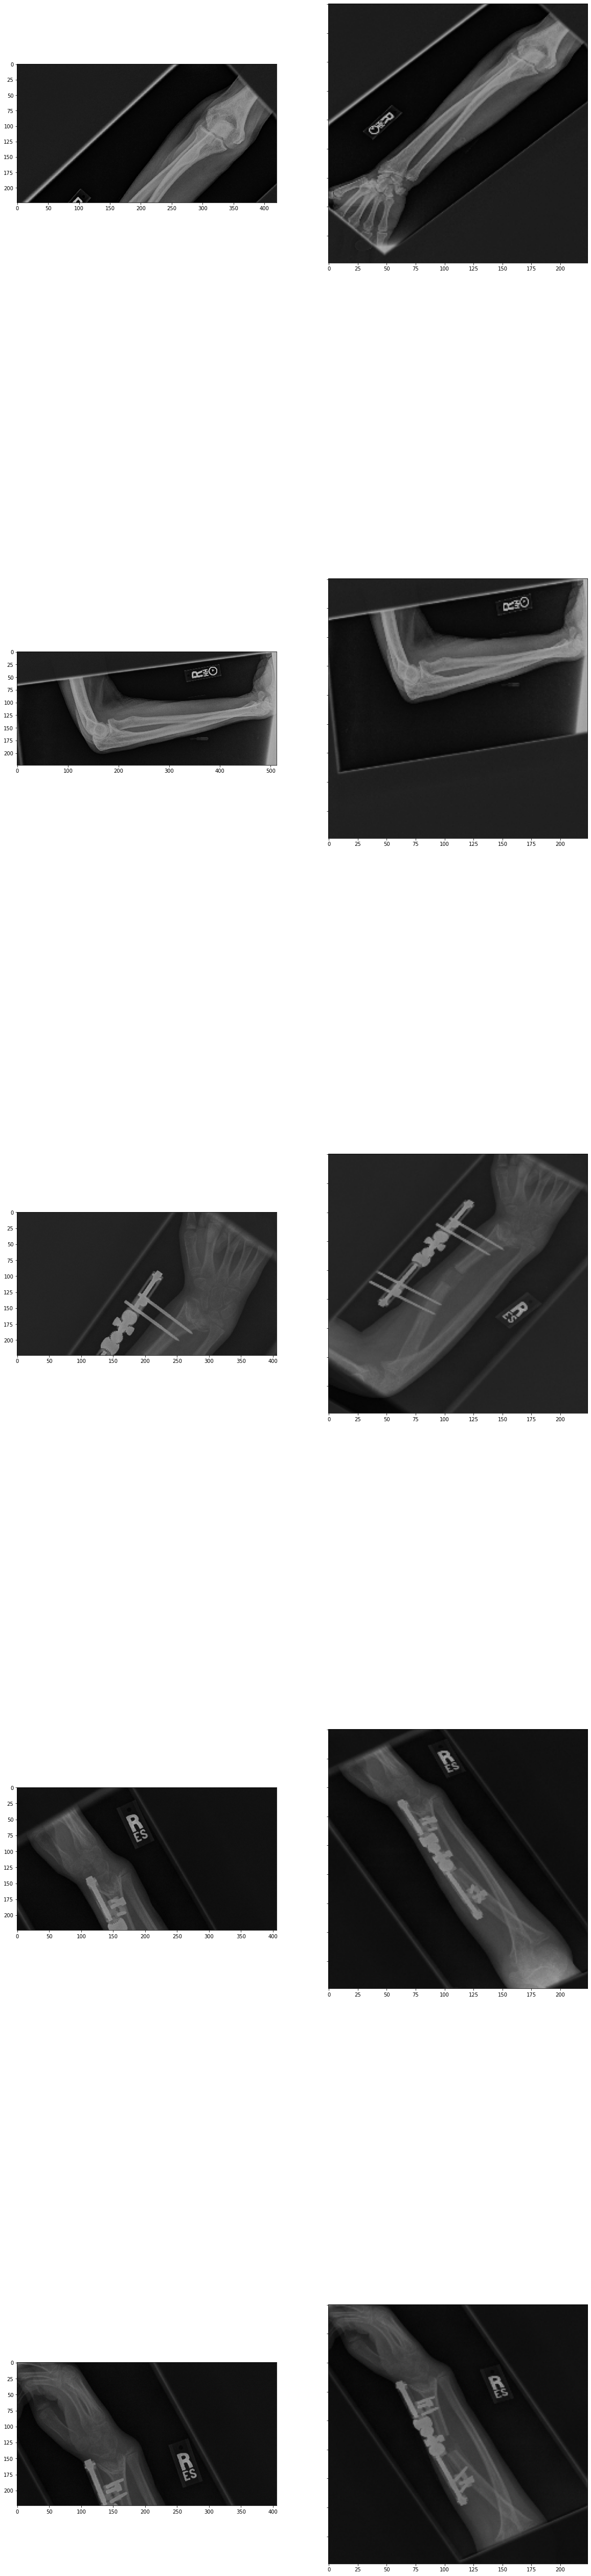

In [20]:
fig,ax=plt.subplots(5,2,sharey=True,figsize=(20,100))
image_dict={}
image_dict['images']=[]
image_dict['label']=[]
count=0
for index,row in tqdm(train_df.head().iterrows()):
  img_arr=cv2.imread(row['img_path'])
  ax[count,0].imshow(img_arr)
  
  resized_arr=cv2.resize(img_arr,(224,224))
  
  ax[count,1].imshow(resized_arr)
  count+=1
                     
  

#image_dict['images']=(image_dict['images']-mean_imagenet)/std_imagenet

# Creating image generators with simple preprocessing and options for data augmentation

In [21]:
def returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=0,horizontal_flip=False):
  datagen=ImageDataGenerator(
    horizontal_flip=horizontal_flip,
    #vertical_flip=True,
    rotation_range=rotation_range,
    #fill_mode='nearest',
    #preprocessing_function=preprocess_input)
    rescale=1./255.)



  train_gen=datagen.flow_from_dataframe(train_df,
                           x_col='img_path',
                           y_col='label',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='binary',batch_size=8,seed=101)

  
    
  val_gen=datagen.flow_from_dataframe(test_df,
                           x_col='img_path',
                           y_col='label',
                           target_size=IMG_SIZE,
                           color_mode='rgb',
                           class_mode='binary', batch_size=1,seed=101)
    
    
  return train_gen, val_gen



In [22]:
train_gen_224,val_gen_224=returnImgGen(train_df,test_df)

Found 1825 validated image filenames belonging to 2 classes.
Found 301 validated image filenames belonging to 2 classes.


In [23]:
def plot_val_train_loss(hist):
  loss_train = hist.history['loss']
  loss_val = hist.history['val_loss']
  epochs = range(1,len(hist.history['val_loss'])+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Augmented Data Image Generators

In [24]:
train_gen_aug,val_gen_aug=returnImgGen(train_df,test_df,IMG_SIZE=(224,224),rotation_range=30,horizontal_flip=True)

Found 1825 validated image filenames belonging to 2 classes.
Found 301 validated image filenames belonging to 2 classes.


# DenseNet169 with Augmentation

In [25]:
weight_path="{}_weights.best.hdf5".format('best_densenet_forearm_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model17=Sequential()
model17.add(DenseNet169(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model17.add(Flatten())
model17.add(Dense(1, activation='sigmoid'))
model17.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model17.summary()

history17=model17.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/30
229/229 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.6296 - mse: 0.2457
Epoch 00001: val_loss improved from inf to 9.12453, saving model to best_densenet_forearm_classifier_weights.best.hdf5
229/229 [==============================] - 847s 4s/step - loss: 0.7162 - a

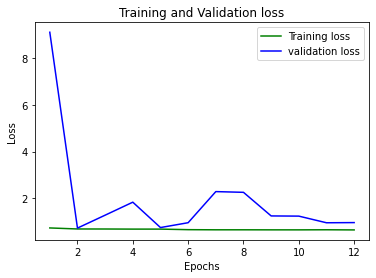

In [26]:
plot_val_train_loss(history17)

In [27]:
from google.colab import files
files.download("best_densenet_forearm_classifier_weights.best.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
model17.load_weights('best_densenet_forearm_classifier_weights.best.hdf5')

In [29]:
Y_pred = model17.predict(val_gen_aug)


In [30]:
predictions = []
for p in Y_pred:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
print('Confusion Matrix')
print(confusion_matrix(val_gen_aug.classes, predictions))
print('Classification Report')
target_names = ['Normal','Abnormal']
print(classification_report(val_gen_aug.classes, predictions, target_names=target_names))

Confusion Matrix
[[133  17]
 [132  19]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.50      0.89      0.64       150
    Abnormal       0.53      0.13      0.20       151

    accuracy                           0.50       301
   macro avg       0.51      0.51      0.42       301
weighted avg       0.51      0.50      0.42       301



In [33]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_gen_aug.classes, predictions)

In [34]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

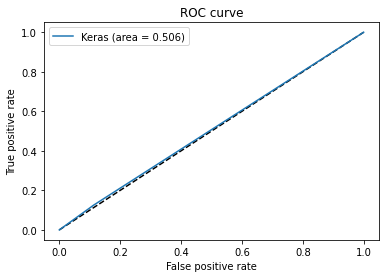

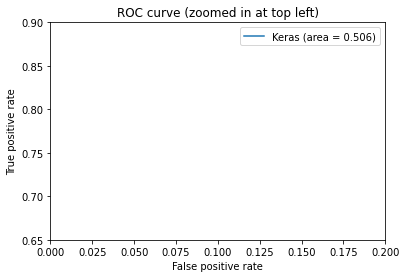

In [35]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# EfficientNet with Augmentation

In [36]:
weight_path="{}_weights.best.hdf5".format('best_efficientnet0_forearm_classifier')

checkpoint3 = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat3 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_lr=0.000001)
#epsilon=0.0001, cooldown=5
early3 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4) # probably needs to be more patient, but kaggle time is limited
callbacks_list_3 = [checkpoint3, early3, reduceLROnPlat3]

opt=keras.optimizers.Adam(learning_rate=0.001)
model19=Sequential()
model19.add(efn.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg'))
model19.add(Flatten())
model19.add(Dense(1, activation='sigmoid'))
model19.compile(loss='binary_crossentropy',optimizer=opt,metrics = ['accuracy','mse'])
model19.summary()

history19=model19.fit(train_gen_aug,validation_data=val_gen_aug,epochs=30,callbacks=callbacks_list_3,shuffle=True)

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________
Epoch 1/30
229/229 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.7216 - mse: 0.1924
Epoch 00001: val_loss improved from inf to 0.67722, saving model to best_efficientnet0_forearm_classifier_weights.best.hdf5
229/229 [==============================] - 36s 158ms/step - loss: 0.58

In [37]:
from google.colab import files
files.download("best_efficientnet0_forearm_classifier_weights.best.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>